# FRIENDLY WARNING
## OpenAI API is being called here. Do not rerun if you're not planning to use any of your OpenAI credits!

# RAG Evaluation

This notebook aims to evaluate the LLM models' performance in the RAG process to decide on the best LLM model to be used for this project. 

There would be 3 criterias of evaluation:
* **Quality evaluation** using cosine similarity to evaluate how similar the responses are compared to ground truth data. 
* **Latency evaluation** to look into the speed (turnaround time) of LLM responses.
* **Tokens usage and cost evaluation** to look into the cost efficiency of each model.

Due to cost and time constraints, only 2 LLM models would be evaluated:
* GPT-4o-mini
* GPT 3.5-turbo

## Process

* Setup RAG flow.
* For each question in ground truth data, generate a response from GPT-4o-mini and GPT 3.5-turbo separately.
* Save the responses, latency and tokens used from each LLM model.
* Compute cosine similarity for each pair of ground truth response-LLM response for each LLM model.
* For each evaluation criteria (quality, latency and cost), perform statistical analysis on the observations.
* Conclude the best model for this project.

## Setup RAG 

**Retrieval**
* Setup Elasticsearch Index with data.
* Elasticsearch retrieval using hybrid search to retrieve relevant context from index above.

**Augment**
* Setup LLM prompt.
* Augment the prompt using retrieved context from Elasticsearch.

**Generation**
* Setup the LLM object (OpenAI, Open source).
* LLM object generates response using augmented prompt.

In [1]:
import pickle
import pandas as pd
import json
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from itertools import cycle
from openai import OpenAI
from tqdm.auto import tqdm
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch

### Setup Retrieval: Setup Elasticsearch Index with data

Reindexing data in case anyone is running this notebook standalone (not following the project flow)

In [2]:
folder = "../data/"
documents_file = "az900_notes_with_vectors.pkl"

In [3]:
df = pd.read_pickle(f"{folder}{documents_file}").set_index("doc_id")

In [4]:
model_name = 'sentence-transformers/all-MiniLM-L12-v2'
embed_model = SentenceTransformer(model_name)
vec_dim = embed_model.get_sentence_embedding_dimension()

/Users/viviensiew/.local/share/virtualenvs/LLM-project-84bUGCVP/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def infer_es_mapping(df, vec_dim):
    '''
    Accepts a pandas dataframe and vector embedding dimension and generates elasticsearch index mapping properties dynamically.
    Index is keyword type.
    Fields end with "_vec" are dense vector types, while others are text types.
    '''
    similarity = 'cosine'    
    es_mapping = {}

    if type(df.index) == pd.Index :
        es_mapping[df.index.name] = {'type': 'keyword'}
        
    # for col, dtype in df.dtypes.iteritems():
    for col in df.columns:
        if col.endswith("_vec"):
            es_mapping[col] = {'type': 'dense_vector', 'dims': vec_dim, 'index': True, 'similarity':similarity}
        else:
            es_mapping[col] = {'type': 'text'}
    return es_mapping

es_mapping_properties = infer_es_mapping(df, vec_dim)

In [6]:
es_client = Elasticsearch('http://localhost:9200') 

def create_es_index(es_mapping_properties, index_name):
    index_settings = {
        "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0
        },
        "mappings": {
            "properties": es_mapping_properties
        }
    }

    es_client.indices.delete(index=index_name, ignore_unavailable=True)
    es_client.indices.create(index=index_name, body=index_settings)

es_index_name = "az900_course_notes"
create_es_index(es_mapping_properties, es_index_name)

In [7]:
documents = pd.read_pickle(f"{folder}{documents_file}").to_dict(orient="records")
for doc in tqdm(documents):
    es_client.index(index=es_index_name, document=doc)

  0%|          | 0/385 [00:00<?, ?it/s]

### Setup Elasticsearch retrieval using hybrid search

To retrieve relevant context. 

In [8]:
def retrieve(question, question_vec, index_name=es_index_name, boost=0.05):
    keyword_query = {"query": question,
                    "fields": ["header", "subheader", "doc_text"],
                    "type": "best_fields",
                    "boost": boost,
                    }

    vector_query = {"query": {"match_all": {}},
                    "script": {
                                "source": """
                                    0.2 * cosineSimilarity(params.query_vector, 'header_vec') + 
                                    0.2 * cosineSimilarity(params.query_vector, 'subheader_vec') + 
                                    0.6 * cosineSimilarity(params.query_vector, 'doc_text_vec') + 1
                                """,
                                "params": {"query_vector": question_vec}
                            }
                   }
    
    hybrid_query = {
        "bool": {
            "must": [{"multi_match": keyword_query},
                     {"script_score": vector_query}
                    ]
            },
        }

    search_query = {
        "query": hybrid_query,
        "size": 5,
        "_source": ['doc_id', 'header', 'subheader', 'document', 'doc_text']
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

### Setup Augment 

Create LLM prompt template to be augmented with retrieved context from Elasticsearch.

In [9]:
def augment(question, search_results):
    '''
    Accepts a question and search results
    Returns a prompt augmented with question and context generated from search results
    '''
    prompt_template = """
You're a friendly course instructor helping students to understand topics in the Azure Fundamentals AZ-900 course. Answer the QUESTION based on the CONTEXT in a user-friendly way.
Use only the information from the CONTEXT to answer the QUESTION. 

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"Topic: {doc['header']}\nSub-topic: {doc['subheader']}\nNotes: {doc['doc_text']}\n\n"
    
    prompt = prompt_template.format(question=question, context=context).strip()
    return prompt

### Setup Generate using OpenAI client

You will need setup a `.env` file with your own OpenAI API key to rerun RAG evaluation. 

Sample `.env` file for this project:
```
OPENAI_API_KEY=your API key here
```

In [10]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") 

In [11]:
client = OpenAI()

def generate(prompt, model='gpt-4o-mini'):
    '''
    Accepts a prompt and (optional) an OpenAI chat API model of choice
    Returns an LLM response, tokens usage info, and total time for generating response.
    '''
    start_time = time.time()
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    latency = time.time() - start_time
    return response.choices[0].message.content, response.usage, latency

### Setup RAG flow

In [12]:
def rag(query, model):
    search_results = retrieve(query['question'], query['question_vec'])
    # for doc in search_results:
    #     print(doc)
    prompt = augment(query['question'], search_results)
    response, usage, latency = generate(prompt, model)
    return response, usage, latency

### Load ground truth data

Generate unique sequence to identify the 5 questions per document.

In [13]:
ground_truth_file = "ground-truth-data.pkl"
df_truth = pd.read_pickle(f"{folder}{ground_truth_file}")

In [14]:
# Unique sequence: doc_id append with running number from 1 to 5, since each doc has 5 questions.
df_truth["idx"] = [f"{doc_id}_{i}" for i,doc_id in zip(cycle([1,2,3,4,5]), df_truth["doc_id"].tolist())]
df_truth

,doc_id,question,question_vec,idx
0,08e49f1028_1,What is the primary characteristic of Infrastr...,"[-0.0061842897, -0.026708089, -0.009343912, -0...",08e49f1028_1_1
1,08e49f1028_1,How much control does a customer have over clo...,"[0.06669134, -0.040444482, -0.10285918, 0.0190...",08e49f1028_1_2
2,08e49f1028_1,What type of cloud service provides the maximu...,"[0.054696202, -0.057140283, -0.03228103, 0.005...",08e49f1028_1_3
3,08e49f1028_1,"In the context of IaaS, what does 'customer co...","[-0.03537042, -0.004027559, -0.078389645, 0.03...",08e49f1028_1_4
4,08e49f1028_1,Which cloud service model allows users to mana...,"[0.049779054, -0.10544806, -0.04841407, -0.025...",08e49f1028_1_5
...,...,...,...,...
1920,a407052ee6_26,What features and tools can be used for govern...,"[0.05051794, 0.001501831, -0.0082640555, -0.00...",a407052ee6_26_1
1921,a407052ee6_26,How can Azure tools help keep resources in com...,"[-0.010703981, 0.03538625, -0.056508645, 0.004...",a407052ee6_26_2
1922,a407052ee6_26,What role does governance play in managing an ...,"[0.05046291, 0.040069252, 0.008615176, -0.0438...",a407052ee6_26_3
1923,a407052ee6_26,Which regulatory requirements can be addressed...,"[0.0348005, 0.05349125, -0.025269153, -0.04674...",a407052ee6_26_4


In [15]:
ground_truth = df_truth.to_dict(orient="records")

**Test rag flow with a single ground truth record**

In [16]:
test_record = ground_truth[18]
test_response, test_usage, test_latency = rag(test_record, model='gpt-4o-mini')
test_usage

CompletionUsage(completion_tokens=181, prompt_tokens=448, total_tokens=629)

In [17]:
print(f"Prompt tokens used: {test_usage.prompt_tokens},\nResponse tokens: {test_usage.completion_tokens},\nLatency: {test_latency:.3f} seconds.")
print(f"QUESTION: {test_record['question']}")
print(f"RESPONSE: {test_response}")

Prompt tokens used: 448,
Response tokens: 181,
Latency: 2.272 seconds.
QUESTION: How does IaaS differ from other cloud service models in terms of customer responsibility?
RESPONSE: In the context of the Azure Fundamentals AZ-900 course, IaaS (Infrastructure as a Service) differs from other cloud service models like PaaS (Platform as a Service) and SaaS (Software as a Service) mainly in terms of customer responsibility. 

With IaaS, the customer has the largest share of responsibility in the shared responsibility model. This means that when you choose IaaS, you are responsible for managing the operating systems, network controls, applications, and identity and infrastructure. On the other hand, with PaaS and SaaS, the service provider (like Microsoft) takes on more responsibility for managing these aspects, while the customer's role is reduced.

In summary, if you opt for IaaS, you take on more of the management and control of the cloud resources, unlike PaaS and SaaS where the provider

### Execute RAG

Execute RAG and save the LLM responses for evaluation step

In [21]:
original_doc = {}
for d in tqdm(documents):
    original_doc[d["doc_id"]] = {"header": d["header"],
                                "subheader": d["subheader"],
                                "doc_text": d['doc_text']}

  0%|          | 0/385 [00:00<?, ?it/s]

In [25]:
responses = {}

In [27]:
for doc in tqdm(ground_truth):
    if doc["idx"] in responses:
        continue
    response_4o, usage_4o, latency_4o = rag(doc, model='gpt-4o-mini')
    response_35, usage_35, latency_35 = rag(doc, model='gpt-3.5-turbo')
    
    responses[doc["idx"]] = {
        "doc_id": doc["doc_id"],
        "question": doc["question"],
        "doc_text": original_doc[doc["doc_id"]]["doc_text"],
        "response_4o": response_4o,
        "usage_4o": usage_4o,
        "latency_4o": latency_4o,
        "response_35": response_35,
        "usage_35": usage_35,
        "latency_35": latency_35,
    }
    

  0%|          | 0/1925 [00:00<?, ?it/s]

### Backup RAG responses 

Save a copy of the generated responses, latency and token info.

In [35]:
answers = []

for k,v in responses.items():
    rcd = {
        "idx": k,
        "doc_id": v["doc_id"],
        "question": v["question"],
        "doc_text": v["doc_text"],
        "response_4o": v["response_4o"],
        "prompt_tokens_4o": v["usage_4o"].prompt_tokens,
        "completion_tokens_4o": v["usage_4o"].completion_tokens,
        "latency_4o": v["latency_4o"],
        "response_35": v["response_35"],
        "prompt_tokens_35": v["usage_35"].prompt_tokens,
        "completion_tokens_35": v["usage_35"].completion_tokens,
        "latency_35": v["latency_35"],
    }
    answers.append(rcd)

In [37]:
df_responses = pd.DataFrame(answers)

In [39]:
df_responses.head()

,idx,doc_id,question,doc_text,response_4o,prompt_tokens_4o,completion_tokens_4o,latency_4o,response_35,prompt_tokens_35,completion_tokens_35,latency_35
0,08e49f1028_1_1,08e49f1028_1,What is the primary characteristic of Infrastr...,Customer has maximum control of cloud resources.,The primary characteristic of Infrastructure a...,352,96,1.221932,The primary characteristic of Infrastructure a...,341,63,1.415287
1,08e49f1028_1_2,08e49f1028_1,How much control does a customer have over clo...,Customer has maximum control of cloud resources.,In an Infrastructure as a Service (IaaS) model...,435,102,2.132323,"In Infrastructure as a Service (IaaS), a custo...",425,38,1.006800
2,08e49f1028_1_3,08e49f1028_1,What type of cloud service provides the maximu...,Customer has maximum control of cloud resources.,The type of cloud service that provides the ma...,387,64,0.902814,Infrastructure as a Service (IaaS) provides th...,382,18,0.800158
3,08e49f1028_1_4,08e49f1028_1,"In the context of IaaS, what does 'customer co...",Customer has maximum control of cloud resources.,In the context of IaaS (Infrastructure as a Se...,400,109,1.929542,'Customer control' in the context of IaaS refe...,385,39,1.005422
4,08e49f1028_1_5,08e49f1028_1,Which cloud service model allows users to mana...,Customer has maximum control of cloud resources.,The cloud service model that allows users to m...,463,64,1.006383,The cloud service model that allows users to m...,462,51,1.111021


In [41]:
responses_file = "RAG_evaluation.pkl"
df_responses.to_pickle(f"{folder}{responses_file}")

## Setup evaluation

* Cosine similarity on all data.
* LLM-as-a-judge on 20\% of randomly sampled data.

### Cosine similarity evaluation

We use cosine similarity to measure how similar are the LLM responses to the ground truth information for each question.
* First compute the cosine similarity between ground truth text vector and the responses from GPT-4o-mini and GPT-3.5-turbo separately.
* Evaluate the responses quality of GPT-4o-mini and GPT-3.5-turbo by looking at their cosine similarity statistics. 

In [42]:
def compute_cosine_similarity(answer_llm, answer_orig):
    
    v_llm = embed_model.encode(answer_llm)
    v_orig = embed_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [43]:
similarity_4o = []
similarity_35 = []

for answer in tqdm(answers):
    sim_4o = compute_cosine_similarity(answer["response_4o"], answer["doc_text"])
    similarity_4o.append(sim_4o)
    sim_35 = compute_cosine_similarity(answer["response_35"], answer["doc_text"])
    similarity_35.append(sim_35)

  0%|          | 0/1925 [00:00<?, ?it/s]

In [44]:
df_responses["cosine_4o"] = similarity_4o
df_responses["cosine_35"] = similarity_35

### Statistics of cosine similarity 

In [47]:
df_responses[["cosine_4o", "cosine_35"]].describe()

,cosine_4o,cosine_35
count,1925.000000,1925.000000
mean,0.669936,0.671432
std,0.182144,0.185636
min,-0.023384,-0.024003
25%,0.575839,0.570880
50%,0.704709,0.701098
75%,0.808311,0.810210
max,0.987723,0.992235


### Cosine Similarity evaluation based on statistical analysis

* The values of cosine similarity ranges from -1 to 1, where values closer to -1 indicates higher dissimilarity and values closer to 1 indicates higher similarity.
* Hence, responses with cosine similarity closer to 1 indicate better response quality.

With this in mind,
* On average, GPT-3.5-turbo is slightly more similar to the ground truth info than GPT-4o-mini (0.671432 v.s. 0.669936)
* However, looking at the 50\% percentile, GPT-4o-mini's top 50\% responses scored at least 0.704709 compared to GPT-3.5-turbo lower similarity value at 0.701098.
* The best response from GPT-3.5-turbo scored 0.992235 while GPT-4o-mini scored 0.987723.

Therefore based on the statistics alone, **there is no clear winner** of which LLM is the better LLM for this use case.

/var/folders/k5/_r7c2p9n4l7c8mj8yt2hzxgr0000gn/T/ipykernel_1797/2611738501.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_responses['cosine_4o'], label='GPT-4o-mini')
/var/folders/k5/_r7c2p9n4l7c8mj8yt2hzxgr0000gn/T/ipykernel_1797/2611738501.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

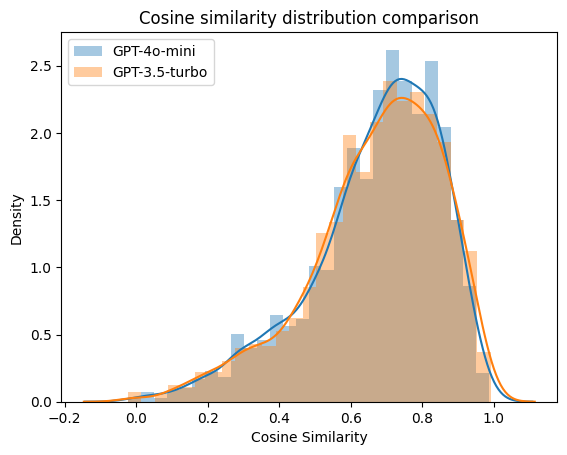

In [54]:
sns.distplot(df_responses['cosine_4o'], label='GPT-4o-mini')
sns.distplot(df_responses['cosine_35'], label='GPT-3.5-turbo')
plt.title("Cosine similarity distribution comparison")
plt.xlabel("Cosine Similarity")
plt.legend()
plt.show()

Backup responses with cosine similarity computation

In [52]:
df_responses.to_pickle(f"{folder}{responses_file}")

### Latency evaluation

Latency describes the time it takes for an LLM to generate a response back. Ideally a lower latency is preferred as this indicates faster performance and turnaround to the users.

In [53]:
df_responses[["latency_4o", "latency_35"]].describe()

,latency_4o,latency_35
count,1925.000000,1925.000000
mean,1.781027,1.265978
std,1.403048,0.491002
min,0.506272,0.469113
25%,1.090739,0.932937
50%,1.485518,1.197740
75%,2.052013,1.492924
max,33.871729,5.834809


### Latency evaluation based on statistical analysis

With lower latency to look for in mind,
* Overall, **GPT-3.5-turbo has a lower latency** than GPT-4o-mini.
* On average, GPT-3.5-turbo is slightly faster than GPT-4o-mini (1.265978 seconds v.s. 1.781027 seconds)
* In addition, looking at the standard deviation, GPT-3.5-turbo's latency is less varied, giving an impression of a more stable prediction in terms of response time range.
* When it comes to outliers, one of GPT-4o-mini's responses recorded a high latency of 33.871729 seconds, giving an impression of potentially erratic response time.

Therefore based on the statistics alone, **GPT-3.5-turbo is the clear winner** here.

/var/folders/k5/_r7c2p9n4l7c8mj8yt2hzxgr0000gn/T/ipykernel_1797/4062356435.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_responses['latency_4o'], label='GPT-4o-mini')
/var/folders/k5/_r7c2p9n4l7c8mj8yt2hzxgr0000gn/T/ipykernel_1797/4062356435.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

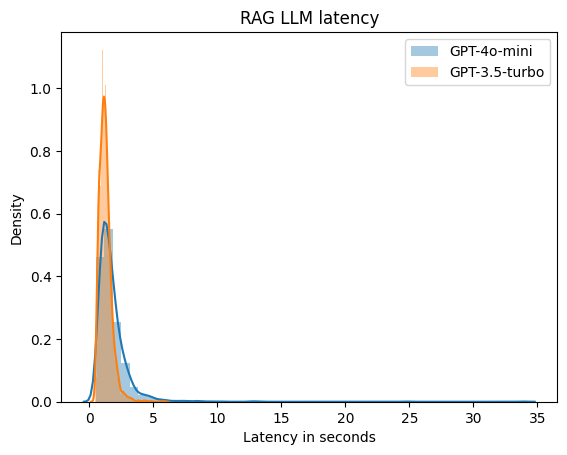

In [56]:
sns.distplot(df_responses['latency_4o'], label='GPT-4o-mini')
sns.distplot(df_responses['latency_35'], label='GPT-3.5-turbo')
plt.title("RAG LLM latency")
plt.xlabel("Latency in seconds")
plt.legend()
plt.show()

### Tokens usage evaluation

Tokens usage affect the overall costs of an LLM and its ROI (Return on investment) in some use cases. 

However, bear in mind that the LLM provider charges are different and can have a greater bearing on costs compared to tokens usage:
| LLM model | Input | Output |
|-----------|-------|--------|
| GPT-3.5-turbo| \$0.50 / 1M tokens | \$1.50 / 1M tokens |
| GPT-4o-mini | \$0.150 / 1M tokens | \$0.600 / 1M tokens |

In [59]:
df_responses[["prompt_tokens_4o", "prompt_tokens_35"]].describe()

,prompt_tokens_4o,prompt_tokens_35
count,1925.000000,1925.000000
mean,509.268052,512.423896
std,136.614169,137.694070
min,261.000000,259.000000
25%,409.000000,411.000000
50%,479.000000,482.000000
75%,589.000000,592.000000
max,1075.000000,1081.000000


In [60]:
df_responses[["completion_tokens_4o", "completion_tokens_35"]].describe()

,completion_tokens_4o,completion_tokens_35
count,1925.000000,1925.000000
mean,122.144935,54.723636
std,64.308252,27.995591
min,15.000000,7.000000
25%,73.000000,34.000000
50%,107.000000,52.000000
75%,160.000000,71.000000
max,420.000000,214.000000


### Tokens usage evaluation based on statistical analysis

The prompt tokens largely depend on how the prompts and contexts are being formatted before sending to LLM. Hence the prompt tokens statictics are closely similar since both GPT-4o-mini and GPT-3.5-turbo receives same augmented prompts.

However for completion tokens which are based on LLM response, it's worth to note that:
* **GPT-4o-mini clearly uses more tokens compared to GPT-3.5-turbo**, a little more than double the number of tokens to be exact.

Costs wise, GPT-4o-mini costs 60\% less than GPT-3.5-turbo for completion tokens and 70\% less than GPT-3.5-turbo for prompt tokens.

These are the cost for the RAG execution on ground truth data:
* GPT-4o-mini: \$0.28
* GPT-3.5-turbo: \$0.64

Hence, in terms of cost effectiveness, **GPT-4o-mini is clearly the winner**.

## Conclusion

* The **responses' quality** from GPT-3.5-turbo and GPT-4o-mini are **similar**.
* In terms of **response speed**, **GPT-3.5-turbo** is slightly faster by $\approx 0.5$ seconds on average compared to GPT-4o-mini.
* **Cost-wise**, **GPT-4o-mini** is more than 50\% less than GPT-3.5-turbo.

Ultimately the decision on the best LLM model for this project depends largely on the use case.

As this project is to build an **Azure Foundation study buddy**, hence it needs to consider that:
* This application is more for short-term usage since users would only study this course for a few months.
* Most people look for cost-effective study solutions whenever possible and would be less willing to spend twice as much if a slightly slower but cheaper solution is available.

Hence, the final decision for the **best model** would be **GPT-4o-mini**. 